In [1]:
# Force reload of modules during development
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv

import sys
sys.path.append(str(Path.cwd().parent))

from ingestion.database import get_connection
from features.database import get_raw_series, get_features, upsert_features
from features.compute import compute_all_features
from features.basic import compute_all_basic_features
from features.cleaning import validate_data_quality

In [3]:
# Load environment and connect to database
load_dotenv()
db_password = os.getenv('DB_PASSWORD')

conn = get_connection(password=db_password)
print("Connected to database")

Connected to database


In [7]:
# Inspect raw data
df_raw = get_raw_series(conn, ticker='^GSPC', start_date='2010-01-01')
print(f"Loaded {len(df_raw)} rows for GSPC")
print(f"\nDate range: {df_raw['dt'].min()} to {df_raw['dt'].max()}")
df_raw.head(10)

Loaded 4012 rows for GSPC

Date range: 2010-01-04 to 2025-12-12


,ticker,asset_class,dt,value,source
0,^GSPC,EQUITY,2010-01-04,1132.989990,yfinance
1,^GSPC,EQUITY,2010-01-05,1136.520020,yfinance
2,^GSPC,EQUITY,2010-01-06,1137.140015,yfinance
3,^GSPC,EQUITY,2010-01-07,1141.689941,yfinance
4,^GSPC,EQUITY,2010-01-08,1144.979980,yfinance
5,^GSPC,EQUITY,2010-01-11,1146.979980,yfinance
6,^GSPC,EQUITY,2010-01-12,1136.219971,yfinance
7,^GSPC,EQUITY,2010-01-13,1145.680054,yfinance
8,^GSPC,EQUITY,2010-01-14,1148.459961,yfinance
9,^GSPC,EQUITY,2010-01-15,1136.030029,yfinance


In [17]:
# Test basic feature computation for a single ticker
df_test = df_raw[['dt', 'value']].copy()
df_test = df_test.set_index('dt')

features = compute_all_basic_features(df_test, '^GSPC', 'EQUITY').set_index('dt')
print(f"Computed {len(features)} features")
print(f"Unique features: {features['feature'].unique()}")
features.head(10)

Computed 35902 features
Unique features: ['^GSPC_LEVEL' '^GSPC_RET_1D' '^GSPC_RET_5D' '^GSPC_RET_20D'
 '^GSPC_RET_60D' '^GSPC_MOM_20D' '^GSPC_MOM_60D' '^GSPC_VOL_20D'
 '^GSPC_VOL_60D']


,ticker,asset_class,feature,value
dt,,,,
2010-01-04,^GSPC,EQUITY,^GSPC_LEVEL,1132.989990
2010-01-05,^GSPC,EQUITY,^GSPC_LEVEL,1136.520020
2010-01-06,^GSPC,EQUITY,^GSPC_LEVEL,1137.140015
2010-01-07,^GSPC,EQUITY,^GSPC_LEVEL,1141.689941
2010-01-08,^GSPC,EQUITY,^GSPC_LEVEL,1144.979980
2010-01-11,^GSPC,EQUITY,^GSPC_LEVEL,1146.979980
2010-01-12,^GSPC,EQUITY,^GSPC_LEVEL,1136.219971
2010-01-13,^GSPC,EQUITY,^GSPC_LEVEL,1145.680054
2010-01-14,^GSPC,EQUITY,^GSPC_LEVEL,1148.459961


In [18]:
features[features['feature'] == '^GSPC_RET_20D']['value']

dt
2010-02-02   -0.026187
2010-02-03   -0.034526
2010-02-04   -0.065102
2010-02-05   -0.066130
2010-02-08   -0.077067
                ...   
2025-12-08    0.017493
2025-12-09    0.001183
2025-12-10    0.005853
2025-12-11    0.007310
2025-12-12    0.013346
Name: value, Length: 3992, dtype: float64

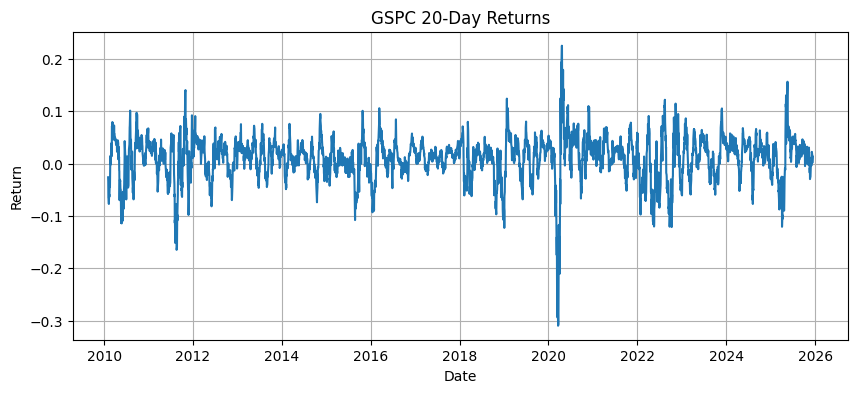

In [19]:
# Visualize feature distributions
import matplotlib.pyplot as plt

if '^GSPC_RET_20D' in features['feature'].values:
    ret_20d = features[features['feature'] == '^GSPC_RET_20D']['value']
    plt.figure(figsize=(10, 4))
    plt.plot(ret_20d.index, ret_20d.values)  # type: ignore
    plt.title('GSPC 20-Day Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.show()

In [ ]:
# Run full feature computation pipeline
# This computes all features for all tickers and stores them in the database

result = compute_all_features(
    conn,
    version='V1_BASELINE',
    start_date='2010-01-01',
    ticker_filter=None  # None = all tickers
)

print("\nFeature computation summary:")
print(result)

Starting feature computation (version: V1_BASELINE)...
Loading raw data...
Loaded 54 tickers
Cleaning and preparing data...
Computing basic features...
  Computed 1277051 basic features
Computing spread features...
  Computed 52350 spread features
Computing ratio features...
  Computed 46583 ratio features
Computing global aggregates...
  Computed 38439 aggregate features
Combining all features...
Total features computed: 1414423
Unique features: 384
Date range: 2010-01-01 to 2025-12-14
Storing features in database (version: V1_BASELINE)...


In [ ]:
# Inspect computed features
df_features = get_features(conn, version='V1_BASELINE', start_date='2020-01-01')
print(f"Loaded {len(df_features)} feature rows")
print(f"Unique features: {df_features['feature'].nunique()}")
print(f"\nFeature types:")
print(df_features['feature'].value_counts().head(20))

In [ ]:
# Example: View specific feature over time
feature_name = 'GSPC_RET_20D'  # Change to any feature name
df_feature = df_features[df_features['feature'] == feature_name].sort_values('dt')

if not df_feature.empty:
    plt.figure(figsize=(12, 4))
    plt.plot(pd.to_datetime(df_feature['dt']), df_feature['value'])
    plt.title(f'{feature_name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
    print(f"\nStatistics for {feature_name}:")
    print(df_feature['value'].describe())
else:
    print(f"Feature {feature_name} not found")

In [ ]:
# View global aggregate features
global_features = df_features[df_features['ticker'] == 'GLOBAL']
print(f"Global features: {global_features['feature'].unique()}")
print(f"\nSample global features:")
global_features.head(10)

In [ ]:
# Close database connection
conn.close()
print("Database connection closed")